![structure1.png](./img/structure1.png)

# 패키지 import

In [ ]:
import tensorflow as tf
import time
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.cmap'] = 'Greys'

import numpy as np
np.set_printoptions(suppress=True)
np.set_printoptions(precision=2)

In [3]:
# random seed
# 나중에 실행해도 같은 결과 보기 위함
np.random.seed(100)

Instructions for updating:
Use the retry module or similar alternatives.


# 변수 설정

In [1]:
# batch size
batch_size = 50

# training data 한 번 왕복할 때 횟수
one_looptime = int(55000/batch_size)

# learning rate
learning_rate_conv = 1
learning_rate_fc = 1

# data 저장 시 이름
name = 'batch50_lr1'
save_path = '/data/190120_cnn_'

In [2]:
# 학습 횟수 결정
learn_count = one_looptime*5*30

# 상수 및 parameter 정의

In [ ]:
img_size = 28       # input 한 변의 크기
filter_num = 4      # filter 개수
filter_size = 5     # filter 한 변의 크기

In [6]:
# filter 한 변 크기의 절반
# int(a) 하면 a의 소수점이 버림 된다. 
filter_size_half = int(filter_size/2)

# weight 크기
W_conv_shape = (filter_num, filter_size, filter_size)
b_conv_shape = (1,filter_num)
W_fc_shape = (filter_num, img_size, img_size, 10)
b_fc_shape = (1,10)

# parameter 이름 list
params = ['W_conv', 'b_conv', 'W_fc', 'b_fc', 
          'W_conv_ing', 'b_conv_ing', 'W_fc_ing', 'b_fc_ing', 
          'error']

# parameter random 초기 값. (범위 : -1 ~ +1)
# ing 는 중간 학습 과정 중의 data 저장 위함. 어떤 식으로 바뀌는지 보기 위해
data_params = {'W_conv' : 2*np.random.rand(W_conv_shape[0], W_conv_shape[1], W_conv_shape[2]) - 1,
               'b_conv' : 2*np.random.rand(b_conv_shape[0], b_conv_shape[1]) - 1,
               'W_fc' : 2*np.random.rand(W_fc_shape[0], W_fc_shape[1], W_fc_shape[2], W_fc_shape[3]) - 1,
               'b_fc' : 2*np.random.rand(b_fc_shape[0],b_fc_shape[1]) - 1,
               'W_conv_ing' : [],
               'b_conv_ing' : [],
               'W_fc_ing' : [],
               'b_fc_ing' : [],
               'error' : []}

# 필요한 함수 정의

In [4]:
# Padding 함수 정의
def padding(X, image_size=28):
    
    # Padding 할 사이즈로 빈 배열 생성
    padd = np.zeros((image_size + filter_size_half*2,image_size + filter_size))

    # 빈 배열 중앙에 데이터 넣기
    # 상하좌우 공백을 필터 사이즈의 절반으로 함
    padd[filter_size_half : filter_size_half + image_size,
         filter_size_half : filter_size_half + image_size] = X
    
    # Padding 완료 반환
    return padd

# input 을 convolution 계산함
# input 은 2d 배열이고, padding 한 것을 받음
def calc_conv(X_padding, W, b, image_size=28, strides=1):
    
    # convolution 계산한 뒤 한 변의 크기 계산
    conv_size = int(image_size/strides)
    
    # 출력할 빈 배열 만들기 
    output = np.zeros((filter_num, conv_size, conv_size))

    # output 계산
    for k in range(filter_num):
        for i in range(conv_size):
            for j in range(conv_size):
                i = i*strides
                j = j*strides
                output[k,i,j] = np.sum(X_padding[i:i+filter_size, j:j+filter_size] * W[k])+ b[0,k]
    
    # output 반환
    return output


# Fully connected 계산
def calc_fc(X_conv, W_fc, b_fc):
    
    # output 빈 배열 만들기
    output = np.zeros((1,10))
    
    # output 계산
    for p in range(10):
        output[0,p] = np.sum(X_conv*W_fc[:,:,:,p]) + b_fc[0,p]
    
    # output 반환
    return output

        
# Sigmoid 함수 정의
def sigmoid(X):   
    return 1/(np.exp(-X) + 1)

# Input data 불러오기

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


# 학습했던 parameter 불러오기(선택)

In [ ]:
# 불러 불러와
for i in range(len(params)):
    data_params.update({params[i]: 
                        np.load(save_path + name +'_' + params[i] + '.npy')})

# list로 바꾸기
# 아래 학습하면서 계속 data 쌓으려면 list로 바꿔야 함
data_params['error'] = list(data_params['error'])
W_conv_ing = []
b_conv_ing = []
W_fc_ing = []
b_fc_ing = []

# ing data 옮겨 담기 1
for i in range(len(data_params['W_fc_ing'])):
    W_conv_ing.append(data_params['W_conv_ing'][i])
    b_conv_ing.append(data_params['b_conv_ing'][i])
    W_fc_ing.append(data_params['W_fc_ing'][i])
    b_fc_ing.append(data_params['b_fc_ing'][i])

# ing data 옮겨 담기 2
data_params['W_conv_ing'] = W_conv_ing
data_params['b_conv_ing'] = b_conv_ing
data_params['W_fc_ing'] = W_fc_ing
data_params['b_fc_ing'] = b_fc_ing

# 학습

In [8]:
# 시작시간 저장
start = time.time()
print('start')

# 학습 loop
for n in range(learn_count):
    
    # 학습 중간 weight 저장하기
    if n % one_looptime == 0:
        data_params['W_conv_ing'].append(data_params['W_conv']*1)
        data_params['b_conv_ing'].append(data_params['b_conv']*1)
        data_params['W_fc_ing'].append(data_params['W_fc']*1)
        data_params['b_fc_ing'].append(data_params['b_fc']*1)
        
    ################################## 초기화
    # error 초기화
    error = 0
    
    # 정확도 초기화
    accuracy = 0
    
    # weight 변화량 초기화
    del_W_fc = np.zeros(W_fc_shape)
    del_b_fc = np.zeros(b_fc_shape)
    del_W_conv = np.zeros(W_conv_shape)
    del_b_conv = np.zeros(b_conv_shape)

    # batch size 만큼 학습
    for q in range(batch_size):
        
        # training data 한 loop 돌고 나서 index 맞춰주기 위함
        q = (q + n*batch_size)%55000
        
        ################################## input -> output
        
        # input data & 교사 data
        X_input = mnist.train.images[q].reshape((28,28))
        X_teach = mnist.train.labels[q].reshape((1,10))
        
        # input padding
        X_padding = padding(X_input)
        
        # convolution 층 계산
        X_conv = calc_conv(X_padding, data_params['W_conv'], data_params['b_conv'])
        X_conv_sigmoid = sigmoid(X_conv)
        
        # Fully connected 층 계산
        X_output = calc_fc(X_conv_sigmoid, data_params['W_fc'], data_params['b_fc'])
        X_sigmoid = sigmoid(X_output)

        ################################## output -> input
        accuracy += np.argmax(X_sigmoid) == np.argmax(X_teach)
        
        # 출력층 delta
        del_output_sig = X_sigmoid - X_teach
        error += 0.5 * np.sum(del_output_sig * del_output_sig)
        
        del_output = (X_sigmoid*(1-X_sigmoid)) * del_output_sig
        
        # Fully connected weight 변화량 계산
        for p in range(10):
            del_W_fc[:,:,:,p] += X_conv * del_output[0,p]
        del_b_fc += del_output
        
        # Fully connected 층 delta
        del_conv_sig = np.zeros(X_conv_sigmoid.shape)
        for k in range(filter_num):
            for p in range(10):
                del_conv_sig[k] += data_params['W_fc'][k,:,:,p] * del_output[0,p]
                
        del_conv = (X_conv_sigmoid*(1-X_conv_sigmoid)) * del_conv_sig
        
        # convolution weight 변화량 계산
        for k in range(filter_num):
            for h in range(filter_size):
                for s in range(filter_size):
                    del_W_conv[k,h,s] += np.sum(X_padding[h:h+img_size, s:s+img_size] * del_conv[k])
            del_b_conv[0,k] += np.sum(del_conv[k])
        
    ################################## weight update
    data_params['W_fc'] -= learning_rate_fc * del_W_fc/batch_size
    data_params['b_fc'] -= learning_rate_fc * del_b_fc/batch_size

    data_params['W_conv'] -= learning_rate_conv * del_W_conv/batch_size
    data_params['b_conv'] -= learning_rate_conv * del_b_conv/batch_size
    
    # error 계산
    error = error/batch_size
    
    # error 저장
    data_params['error'].append(error)
    
    # training data 왕복 완료 print
    if n%one_looptime == 0:
        print("loop {0:4d}\t Error : {1:.3f}\t accuracy : {2:.3f}".format(n//one_looptime + 1, error, accuracy/batch_size))
        
    # cpu delay
    time.sleep(0.001)
    
# 최종 걸린 시간 계산
tt = time.time() - start

# 최종 걸린 시간 출력
print("{0:.0f}시간 {1:.0f}분 {2:.0f}초".format((tt//60)//60, (tt//60)%60, tt%60))

start
loop    1	 Error : 0.133	 accuracy : 0.800
loop    2	 Error : 0.136	 accuracy : 0.800
loop    3	 Error : 0.133	 accuracy : 0.800
loop    4	 Error : 0.132	 accuracy : 0.800
loop    5	 Error : 0.133	 accuracy : 0.800
loop    6	 Error : 0.132	 accuracy : 0.800
loop    7	 Error : 0.134	 accuracy : 0.800
loop    8	 Error : 0.136	 accuracy : 0.800
loop    9	 Error : 0.133	 accuracy : 0.800
loop   10	 Error : 0.144	 accuracy : 0.820
loop   11	 Error : 0.135	 accuracy : 0.800
loop   12	 Error : 0.132	 accuracy : 0.800
loop   13	 Error : 0.164	 accuracy : 0.780
loop   14	 Error : 0.133	 accuracy : 0.800
loop   15	 Error : 0.132	 accuracy : 0.800
loop   16	 Error : 0.133	 accuracy : 0.800
loop   17	 Error : 0.136	 accuracy : 0.800
loop   18	 Error : 0.132	 accuracy : 0.800
loop   19	 Error : 0.133	 accuracy : 0.800
loop   20	 Error : 0.156	 accuracy : 0.820
loop   21	 Error : 0.132	 accuracy : 0.800
loop   22	 Error : 0.132	 accuracy : 0.800
loop   23	 Error : 0.134	 accuracy : 0.800
loop 

# save data

In [9]:
# 데이터 저장
# list도 자동으로 array 저장됨
for ii in data_params.keys():
    np.save(save_path + name +'_' + ii + '.npy', data_params[ii])


In [11]:
print(len(data_params['error']))
print(len(data_params['W_fc_ing']))

1043901
950


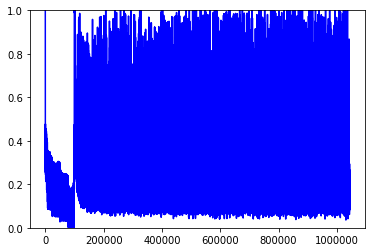

In [12]:
plt.ylim(ymin=0)
plt.plot(data_params['error'],'b')

In [13]:
# test. accuracy check
accuracy_calc = np.zeros((len(mnist.test.images)))
test_num = 10000
not_correct = []

start = time.time()
for q in range(test_num):
    X_input = mnist.train.images[q].reshape((28,28))
    X_teach = mnist.train.labels[q].reshape((1,10))

    X_padding = padding(X_input)

    X_conv = calc_conv(X_padding, data_params['W_conv'], data_params['b_conv'])
    X_conv_sigmoid = sigmoid(X_conv)

    X_output = calc_fc(X_conv_sigmoid, data_params['W_fc'], data_params['b_fc'])
    X_sigmoid = sigmoid(X_output)
    
    corr = np.argmax(X_sigmoid) == np.argmax(X_teach)
    accuracy_calc[q] = corr
    if not corr:
        not_correct.append(q)
    if q%100 == 0:
        print(q)

tt = time.time() - start
print("{0:.0f}분 {1:.0f}초".format(tt//60, tt%60))

accuracy = np.average(accuracy_calc[0:test_num])
print(accuracy)



0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
2분 6초
0.7348


In [14]:
ing_accuracy_list = []
ing_not_correct_idx = []

try:
    ing_accuracy_list = np.load(save_path + name +'_ing_accuracy_list.npy')
    ing_not_correct_idx1 = np.load(save_path + name +'_ing_not_correct_idx.npy')
    ing_accuracy_list = list(ing_accuracy_list)
    
    for i in range(len(ing_not_correct_idx1)):
        ing_not_correct_idx.append([])
        ing_not_correct_idx[i] = ing_not_correct_idx1[i]
        
    print('try')
    
except:
    ing_accuracy_list = []
    ing_not_correct_idx = []
    print('except')

try


In [15]:
# test. accuracy check
accuracy_calc = np.zeros((len(mnist.test.images)))
accum_num = len(ing_accuracy_list)
   
start = time.time()
for ii in range(len(data_params['W_conv_ing']) - accum_num):
    ii += accum_num
    ing_not_correct_idx.append([])
    
    for q in range(len(accuracy_calc)):
        X_input = mnist.train.images[q].reshape((28,28))
        X_teach = mnist.train.labels[q].reshape((1,10))

        X_padding = padding(X_input)

        X_conv = calc_conv(X_padding, data_params['W_conv_ing'][ii], data_params['b_conv_ing'][ii])
        X_conv_sigmoid = sigmoid(X_conv)

        X_output = calc_fc(X_conv_sigmoid, data_params['W_fc_ing'][ii], data_params['b_fc_ing'][ii])
        X_sigmoid = sigmoid(X_output)

        corr = np.argmax(X_sigmoid) == np.argmax(X_teach)
        accuracy_calc[q] = corr
        
        if not corr:
            ing_not_correct_idx[ii].append(q)
            
        if q%100 == 0:
            print(q)

    tt = time.time() - start
    print("{0:.0f}분 {1:.0f}초".format(tt//60, tt%60))

    accuracy = np.average(accuracy_calc)
    ing_accuracy_list.append(accuracy)
    print(accuracy)
    
    if ii%10==0:
        np.save(save_path + name +'_ing_accuracy_list.npy', ing_accuracy_list)
        np.save(save_path + name +'_ing_not_correct_idx.npy', ing_not_correct_idx)
        print("save")

np.save(save_path + name +'_ing_accuracy_list.npy', ing_accuracy_list)
np.save(save_path + name +'_ing_not_correct_idx.npy', ing_not_correct_idx)
print('complete')

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
2분 7초
0.7334
save
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
4분 16초

3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
36분 14초
0.7346
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
38분 21초
0.7338
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900

5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
70분 14초
0.7334
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
72분 22초
0.7336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700

8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
104분 18초
0.7341
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
106분 25초
0.7341
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
86

1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
140분 49초
0.7343
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
142분 57초
0.7343
0
100
200
300
400
500
600
700
800
900
10

3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
175분 6초
0.7343
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
177분 14초
0.7324
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
350

6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
209분 24초
0.7297
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
211분 33초
0.7345
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
61

8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
243분 50초
0.7351
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
245분 59초
0.7346
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
86

1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
280분 9초
0.7361
save
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
282분 20초
0.7327
0
100
200
300
400
500
600
700
800
900
100

3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
313분 60초
0.735
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
316분 4초
0.7349
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600

In [16]:
np.save(save_path + name +'_ing_accuracy_list.npy', ing_accuracy_list)
np.save(save_path + name +'_ing_not_correct_idx.npy', ing_not_correct_idx)